# Python Big Data Analytics with Dask

## Juan Luis Cano Rodríguez - 2018-06-25 @ ICRAT

![Trajectories](img/trajectories_alt.png)

1. Introduction (4 minutes)
    1. Python ecosystem for Data Science (Jake Vanderplas slide)
    2. Limitations (small data)
    3. Mature Big Data tools (PySpark)
2. Dask (5 minutes)
    1. Lazy, graph-based computing engine
    2. Distributed graph evaluation
    3. Familiar APIs, low overhead
    4. Short live demo? Or better show a GIF?
3. Application to Trajectory Prediction (4 minutes)
    1. Problem setting
    2. Infrastructure
    3. Generation of an intermediate index in parquet format
    4. Training
    5. Variables importance
    6. Accuracy + Conclusions
4. Future work (1 minute)
    1. Deeper exploratory analysis and feature engineering
    2. Scale to a cluster for better performance
    3. Dask-ML for training
5. Conclusions (1 minute)

## About me

* Aeronautical Engineer specialized in Orbital Mechanics 🛰
* Founder and president of the **Python España** non profit, as well as co-organizer of **PyConES** 🐍
  - Next edition in Málaga, tickets selling out soon https://2018.es.pycon.org/
* **Software Engineer** at the geospatial infrastructure team in **Satellogic** 🌍
* **Freelancer** for R&D projects
* Open Source advocate and specially about Python for scientific computing

![Juan Luis Cano](img/juanlu_esa.jpg)

# 1. Introduction

## Python for Data Science

* Python is a **dynamic**, **relatively easy to learn**, **general purpose language**
* There is a vast ecosystem of **commercial-friendly, open source libraries** around it
* Growth in the latest years mainly due to adoption in **Data Science**

![Growth major languages](img/growth_major_languages.png)

![Growth pandas](img/growth_pandas.png)

![Ecosystem](img/ecosystem.png)

## Limitations

* All Python libraries were designed for in-memory computing
* On their own, they don't work well with bigger-than-RAM datasets
* Apart from embarrasingly parallel problems, we need other solutions

## Current mature tool: PySpark

* Python API for Spark, a complete distributed computing framework written in Scala (Java derivative)
* Pros: Rich ecosystem, good integration with Big Data technologies (Hadoop, Hive)
* Cons: Python to/from Java serialization is slow and fragile, difficult to debug

![PySpark](img/pyspark.png)

# 2. Dask

> "Dask provides advanced parallelism for analytics, enabling performance at scale for the tools that you love"

<img src="img/dask.svg" width="300px" />

1. Dynamic task scheduling optimized for interactive computation
2. "Big Data" collections like parallel arrays, dataframes, and lists that extend common interfaces like NumPy, Pandas, or Python iterators to larger-than-memory or distributed environments

Dask emphasizes the following virtues:

* **Familiar**: Provides parallelized NumPy array and Pandas DataFrame objects
* **Flexible**: Provides a task scheduling interface for more custom workloads and integration with other projects
* **Native**: Enables distributed computing in Pure Python with access to the PyData stack
* **Fast**: Operates with low overhead, low latency, and minimal serialization necessary for fast numerical algorithms
* **Scales up and down**: Runs resiliently on clusters with 1000s of cores or a laptop in a single process
* **Responsive**: Designed with interactive computing in mind it provides rapid feedback and diagnostics to aid humans

![Schedulers](img/collections-schedulers.png)

In [1]:
from distributed import Client, progress

client = Client()
client

Client Scheduler: tcp://127.0.0.1:32941 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.27 GB


In [2]:
import numpy as np
import dask.array as da

x = np.arange(1000)
y = da.from_array(x, chunks=100)

In [3]:
y

dask.array<array, shape=(1000,), dtype=int64, chunksize=(100,)>

In [4]:
op = y.mean()
op

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>

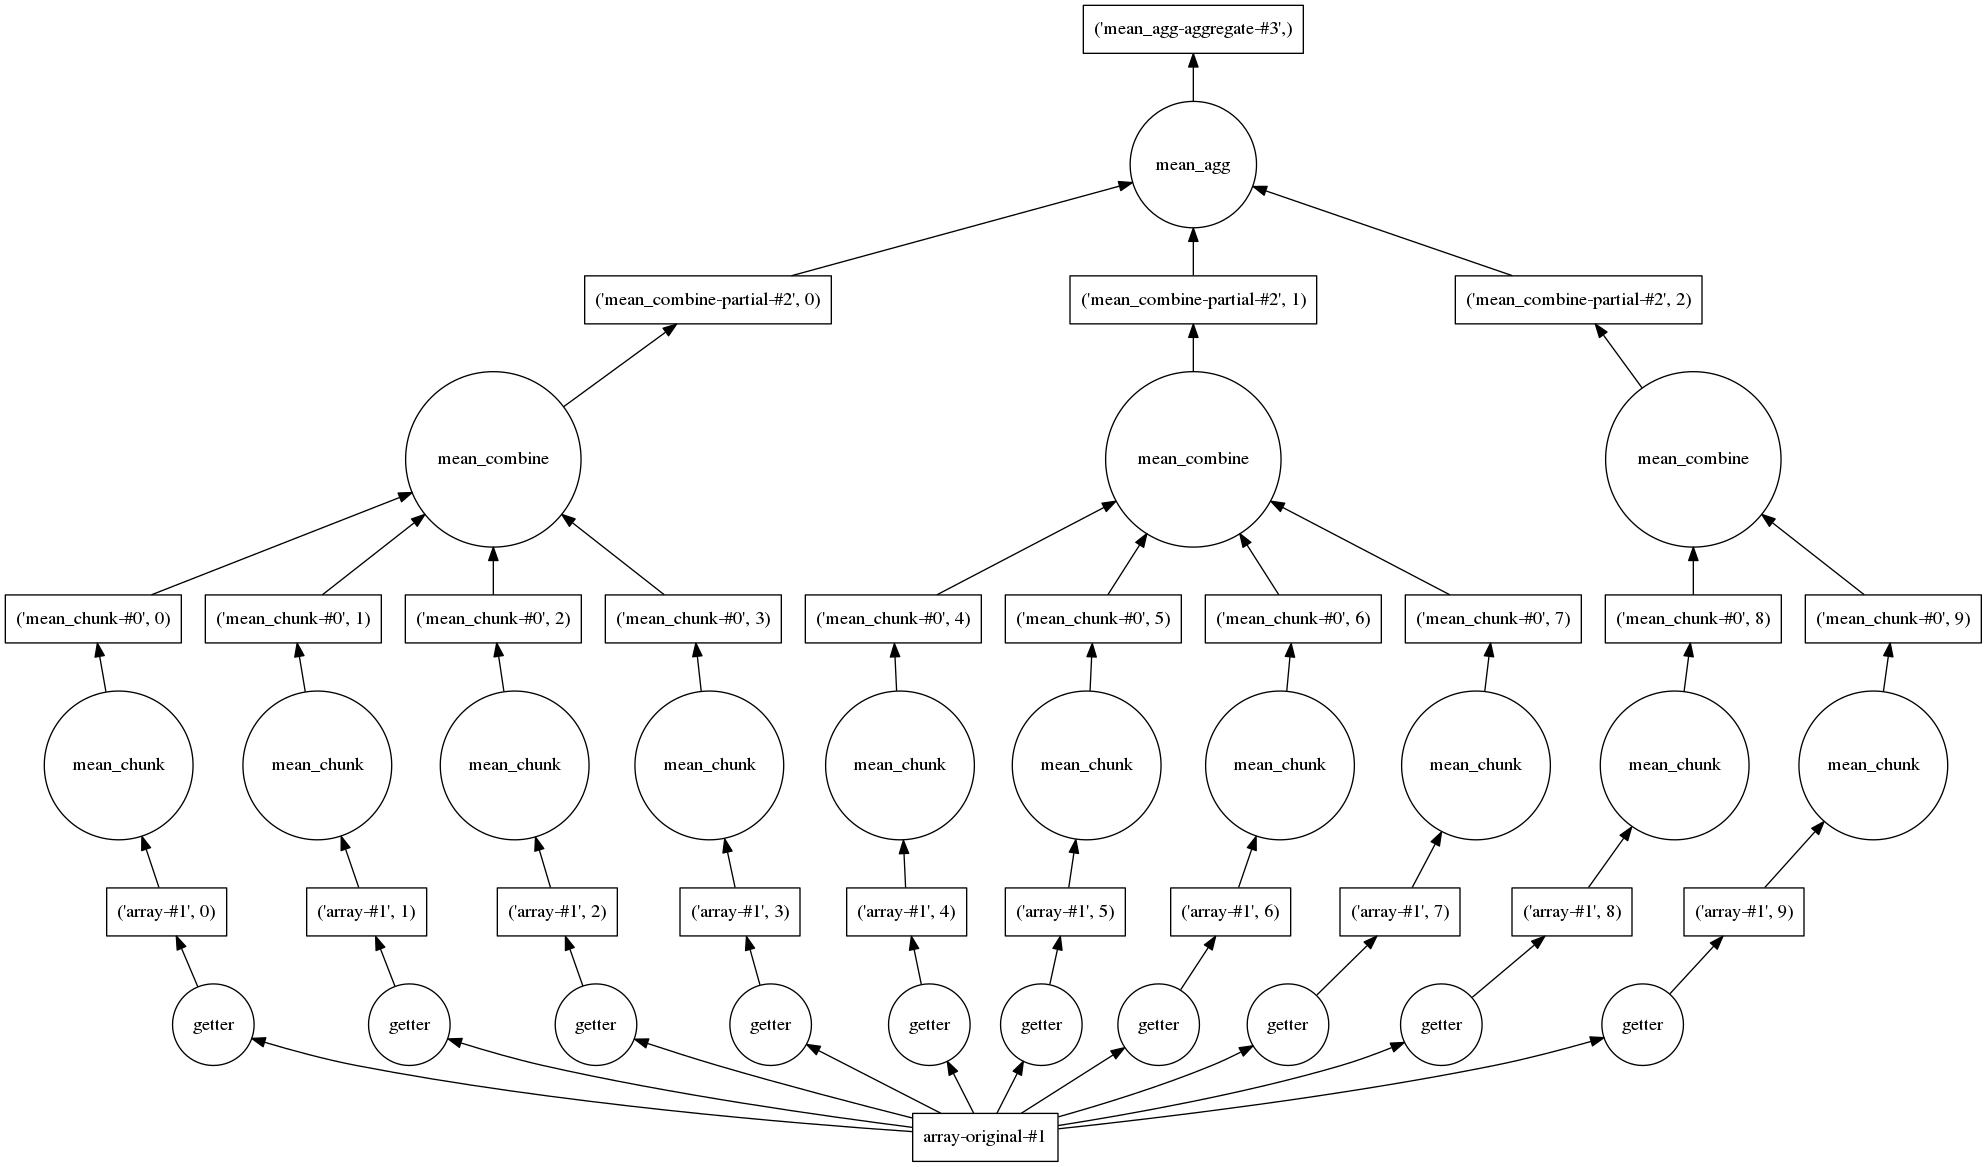

In [5]:
op.visualize()

In [6]:
op.compute()

499.5

In [7]:
import dask.dataframe as dd

df = dd.read_csv("data/yellow_tripdata_*.csv", parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [8]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [9]:
len(df)

12748986

![Progress](img/progress.gif)

# 3. Application to trajectory prediction

|          | \ |         **Predictors (whole flight)**        | \ |           **Target variables (x %)**          |
|----------|---|:--------------------------------------------:|:-:|:---------------------------------------------:|
|          | \ | duration_max, T_mean, p_mean, ..., wkday_Sat | \ | $\lambda$, $\varphi$, duration, distance, H_p |
| Flight 1 | \ |                                              | \ |                                               |
| Flight 2 | \ |                                              | \ |                                               |
| ...      | \ |                                              | \ |                                               |
| Flight N | \ |                                              | \ |                                               |